## Final Project Presentation
### Option B2: Data Project: Substantial Data Collection (Text)
The focus is on the acquisition, cleaning, transformation, organization, and presentation of data.

Paige Yi 12/08/2022

### Import Modules and Get Credentials

In [1]:
"""
Created on Sun Dec  11 13:56:21 2022

@author: jpyi
1.  Install praw by performing a “pip install praw” from a conda shell or from linux shell.  Praw is an 
API that interfaces with the Reddit API.  The API enables a user to access both historical and 
real-time subreddit channel messages.
2. Sign up for a Reddit account if you don’t have one already
3. Create a Reddit App
4. Click onto 'Are you a developer? Create an app...'
5. Fill out the “Create Application” exactly as instructed on the website
6. Once you click the “create app” button, please scroll up and copy YOUR “personal use script” 
and “secret”:
7. Now go to the Python script called keys.py and paste your “client_id”, “client_secret”, 
“username”, “password” into the proper fields, as shown in the example below:

"""

import praw # enables a user to access both historical and real-time subreddit channel messages.
import pandas as pd
import numpy as np
import pytz # # allows accurate and cross platform timezone calculation
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
subreddit_channel = 'politics'
import re
import nltk
from nltk.corpus import stopwords 
import spacy # for named entity recognition(NER)
# load the spacy large English model (en_core_web_lg)
from nltk.probability import FreqDist
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# For importing our word cloud mask image and converting the content into bytes for the Image package
import requests
from io import BytesIO
from PIL import Image   # To read the image data
# Also import STOPWORDS, a set of common English words to remove from our potential words
from wordcloud import WordCloud, STOPWORDS


# developer's credentials for streaming comments, create your own, see above.
reddit = praw.Reddit(
     client_id="CQCXr5pT5FOWh1jYbBcm0A",
     client_secret="_S1EvYlUKoPWzR4UT5Uec70rXYQKzA",
     user_agent="testscript by u/fakebot3",
     username="psjyforte",
     password="Student0723",
     check_for_async=False
 )



### Functions

In [2]:
def conv_time(var):
    # This function handles and converts different timezones by using the pytz module

    tmp_df = pd.DataFrame()
    tmp_df = tmp_df.append(
        {'created_at': var},ignore_index=True)
    tmp_df.created_at = pd.to_datetime(
        tmp_df.created_at, unit='s').dt.tz_localize(
            'utc').dt.tz_convert('US/Eastern') 
    return datetime.fromtimestamp(var).astimezone(pytz.utc)



def get_reddit_data(var_in):
    # This function returns a dictionary with 4 key-value pairs from streamed Reddit comments 
    # Our focus then will be extracting the values associated with key 'body'
    
    tmp_dict = pd.DataFrame()
    tmp_time = None
    try:
        tmp_dict = tmp_dict.append({"created_at": conv_time(
                                        var_in.created_utc)},
                                    ignore_index=True)
        tmp_time = tmp_dict.created_at[0] 
    except Exception as e:
        print (e)
        pass
    tmp_dict = {'msg_id': str(var_in.id),
                'author': str(var_in.author),
                'body': var_in.body,
                'datetime': tmp_time
               }
    return tmp_dict



def get_comment_lst(n_comments):
    # This function takes in a varaible of int type so as to give users flexbility
    # of streaming the exact number of comments desired
    # Since the focus here is to extract the 'body' of the above dict tmp_dict,
    # we append the values associated with the key 'body' to a comment_lst
    # The streaming process will terminate once the list reaches n_comments

    comment_lst = [] # a list of str 
    for comment in reddit.subreddit(subreddit_channel).stream.comments():
        tmp_df = get_reddit_data(comment)
        comment_lst.append(tmp_df['body']) 

        if len(comment_lst) == n_comments:
            break
    return comment_lst



def clean_text(str_in):
    # This function takes in a str and converts it to all lowercase and replace everything but letters with white space
    # AND removes stopwords in comments so as to reduce noises for downstream analyses
    # for our purposes, I also added new words to the stopwords list 
    
    cleaned = re.sub(r'[^A-Za-z]+', ' ', str_in.lower())
    sw = stopwords.words('english') # a list
    update_words = ['http', 'https','r', 'www', 'reddit', 'com', 'wiki','index','approveddomainslist','list','bot','subreddit', 'sounds', 'seems', 'like', 'would', 'could','also', 'still', 'en','org']
    for i in update_words:
        sw.append(i) # update sw list
    tmp = [word for word in cleaned.split() if word not in sw]
    tmp = ' '.join(tmp)   
    return tmp



def get_df(comment_lst):
    # This function takes in a list of comments, cleans each comment in that inputted list
    # then creates a dataframe out of the list of cleaned comments
    # applies three lambda function on the cleaned_comments column, adding three separate columns
    # in particular, the named entity extraction using spacy is a good primer for extracting frequently occuring tokens
    
    new_body = [clean_text(sent) for sent in comment_lst]
    reddit = pd.DataFrame(data=new_body, columns=['cleaned_comments'])
    reddit['word_count'] = reddit.cleaned_comments.apply(lambda x: len(x.split()))
    reddit['letter_count'] = reddit.cleaned_comments.apply(lambda x: len(x) - x.count(' ')) # excludes white spaces
    nlp = spacy.load('en_core_web_lg')
    reddit['named_entity'] = reddit.cleaned_comments.apply(lambda x: nlp(x).ents)  
    return reddit



def get_unigrams(data): # data is a df
    # This function takes in a df and creates 50 most used words/unigrams
    # out of the cleaned_comments column using nltk library
    
    concat_str = data['cleaned_comments'].str.cat(sep=' ') # concatenate all the comments in one single long str
    fdist = FreqDist(concat_str.split()) # takes in a word list
    unigram = fdist.most_common(50)
    return unigram



def get_bigrams(data):
    # This function takes in a df and creates 50 most common word combo/bigrams
    # out of the cleaned_comments column using nltk library

    concat_str = data['cleaned_comments'].str.cat(sep=' ') # concatenate all the comments in one single long str
    bigrams = nltk.bigrams(concat_str.split())
    fdist_bi = FreqDist(bigrams)
    bigram = fdist_bi.most_common(50)
    return bigram



def word_in_text(word_in, str_in):
    # This function takes in two varaibles of str type, 
    # and checks how many times the first varibale word_in occurs in the 2nd var str_in"
    match = re.findall(word_in, str_in)
    if match:
        return len(match)
    return 0



def plot_key_words(list_in, count_in):
    # This function takes in two varaible of list type
    # and creates a barchart using seaborn library
    
    sns.set_style('whitegrid')
    sns.set(color_codes=True) # set seaborn style
    ax = sns.barplot(list_in, count_in)
    ax.set(ylabel='count')
    return plt.show()



def plot_unigrams(df_in):
    # This function takes in a pandas df and plot the 50 most words using nltk and seaborn library
    
    plt.figure(figsize=(15,5))
    concat_str = df_in['cleaned_comments'].str.cat(sep=' ')
    fdist = FreqDist(concat_str.split()) # takes in a word list
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})
    # DataFrame.nlargest(n, columns)
    # Returns the first n rows ordered by columns in descending order.
    d = words_df.nlargest(n = 20, columns="count") # another df
    # plot the 50 most common words
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(xlabel='20 Most Common Words/Unigrams in the Streamed Reddit Comments for Politics', ylabel = 'Word Frequency')
    return plt.show()
    

def plot_bigrams(df_in):
    # This function takes in a pandas df and plot the 50 most words using nltk and seaborn library
    
    fig = plt.figure(figsize = (15, 5))
    first_ele = [str(i[0]) for i in get_bigrams(df_in)]
    second_ele = [i[1] for i in get_bigrams(df_in)]    
    x = first_ele
    y = second_ele
    # print(x)
    # print(y)
    plt.bar(first_ele, second_ele, color ='green')
    # add labels
    plt.xlabel("20 Most Common Words/bigrams in the Streamed Reddit Comments for Politics")
    plt.ylabel("Word Frequency")
    plt.xticks(x, rotation=90)    
    return plt.show()
    


def word_cloud(df_in):
    # This function takes in a df and plot out a word cloud from its cleaned_comments column 
    # using a Trump silouette mask image as the word cloud's background 

    concat_str = df_in['cleaned_comments'].str.cat(sep=' ') # concatenate all the comments in one single long str    
    # Load the Trump mask image path
    url = 'https://www.wpclipart.com/dl.php?img=/American_History/presidents/additional_images/Donald_Trump/Trump_silhouette.png'    
    # Use requests to get the image data and then uses BytesIO and Image.open() to import the image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # Create the wave_mask by converting the image data into a numpy array
    wave_mask = np.array(img)        
    # Make the figure from the concatenated reddit comments
    wordcloud = WordCloud(mask=wave_mask, random_state=80, contour_width=1,
                          contour_color='orange').generate(concat_str)    
    # Create matplotlib figure
    fig = plt.figure(figsize=(15, 10))  
    # Display image on our figure
    plt.imshow(wordcloud, interpolation="bilinear")   
    # Turn off axes and set a dark background to avoid a white area saved around the image
    plt.axis("off")
    plt.style.use('dark_background')
    return plt.show()


###  Data Collection 

In [3]:
########## 1. Data Collection 

my_list = get_comment_lst(300) # stream Reddit comments 
my_list

['Republicans in 2016:\n\n“Quit being dramatic, he’s fine. Better than the alternative.”\n\nRepublicans now, after Trump has actively destroyed the Republican Party from the inside out for the past 6 years:\n\n“…”',
 'But “arbitrary” means based on whim or personal convenience rather than reason or a system. 10 can be arbitrarily close to 0, or a million. It’s arbitrary!',
 'Ayn Rand was a sick-fuck apologist for pathological assholes.',
 'We can hope!!!!',
 'Damn, I just realized I might be Xenophobic.',
 'Win what?',
 'Sounds like a confession to me',
 'What are you saying, please reword this.',
 "What you mean they're not represented? Every vote is represented. Every vote is counted.  Every vote is equal.  And the plurality of the votes will determine the outcome.  Regardless of whether that plurality equals 90%, 50% or even some number much lower than 50% (If there are more than two choices).\n\nAnd that's how the Democratic process works.\n\nThis is literally democracy.",
 "I the 

### Data Preprocessing & Munging 


In [4]:
########## 2. Data Preprocessing & Munging 

reddit = get_df(my_list) # create a pandas df from the streamed comments
reddit

,cleaned_comments,word_count,letter_count,named_entity
0,republicans quit dramatic fine better alternat...,15,107,"((republicans), (republicans), (trump), (repub..."
1,arbitrary means based whim personal convenienc...,13,92,"((million),)"
2,ayn rand sick fuck apologist pathological assh...,7,44,"((ayn, rand),)"
3,hope,1,4,()
4,damn realized might xenophobic,4,27,()
...,...,...,...,...
295,notice skepticism extends elections lose,5,36,()
296,effectively example jury nullification others ...,39,268,"((senate), (senate))"
297,according financial disclosure pension time st...,15,82,()
298,agree loathe except implication green party hu...,72,428,"((democrats),)"


### Data Analyses

In [10]:
########## 3. Data Analyses

unigrams = get_unigrams(reddit) # extract 50 most common unigrams and bigrams from the df
bigrams = get_bigrams(reddit)
unigrams

[('people', 57),
 ('vote', 32),
 ('trump', 31),
 ('politics', 28),
 ('right', 27),
 ('one', 25),
 ('get', 22),
 ('election', 21),
 ('make', 21),
 ('even', 20),
 ('please', 18),
 ('party', 17),
 ('us', 15),
 ('republicans', 14),
 ('every', 14),
 ('see', 14),
 ('know', 14),
 ('democrats', 14),
 ('way', 14),
 ('think', 14),
 ('gop', 13),
 ('votes', 12),
 ('state', 12),
 ('voters', 12),
 ('want', 12),
 ('good', 12),
 ('time', 12),
 ('texas', 12),
 ('mean', 11),
 ('place', 11),
 ('money', 11),
 ('always', 11),
 ('lot', 11),
 ('believe', 11),
 ('mtg', 11),
 ('next', 11),
 ('better', 10),
 ('million', 10),
 ('win', 10),
 ('much', 10),
 ('states', 10),
 ('voting', 10),
 ('care', 10),
 ('comments', 10),
 ('questions', 10),
 ('new', 10),
 ('help', 10),
 ('anyone', 10),
 ('voted', 10),
 ('office', 10)]

In [11]:
bigrams

[(('instagram', 'p'), 8),
 (('next', 'f'), 8),
 (('f', 'instagram'), 7),
 (('young', 'people'), 6),
 (('help', 'make'), 5),
 (('politics', 'comments'), 5),
 (('moderators', 'message'), 5),
 (('message', 'compose'), 5),
 (('compose', 'politics'), 5),
 (('reminder', 'civil'), 4),
 (('civil', 'discussion'), 4),
 (('discussion', 'politics'), 4),
 (('politics', 'civil'), 4),
 (('civil', 'general'), 4),
 (('general', 'courteous'), 4),
 (('courteous', 'others'), 4),
 (('others', 'debate'), 4),
 (('debate', 'discuss'), 4),
 (('discuss', 'argue'), 4),
 (('argue', 'merits'), 4),
 (('merits', 'ideas'), 4),
 (('ideas', 'attack'), 4),
 (('attack', 'people'), 4),
 (('people', 'personal'), 4),
 (('personal', 'insults'), 4),
 (('insults', 'shill'), 4),
 (('shill', 'troll'), 4),
 (('troll', 'accusations'), 4),
 (('accusations', 'hate'), 4),
 (('hate', 'speech'), 4),
 (('speech', 'suggestion'), 4),
 (('suggestion', 'support'), 4),
 (('support', 'harm'), 4),
 (('harm', 'violence'), 4),
 (('violence', 'de

### Data Visualization

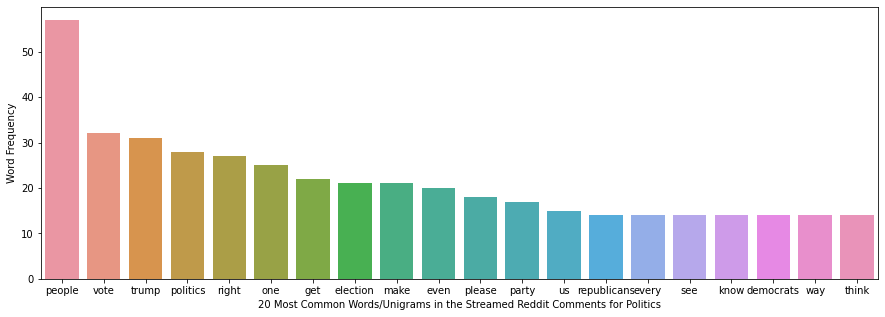

In [12]:
########## 4. Data Visualization 

plot_unigrams(reddit) # create a barchart for the unigrams

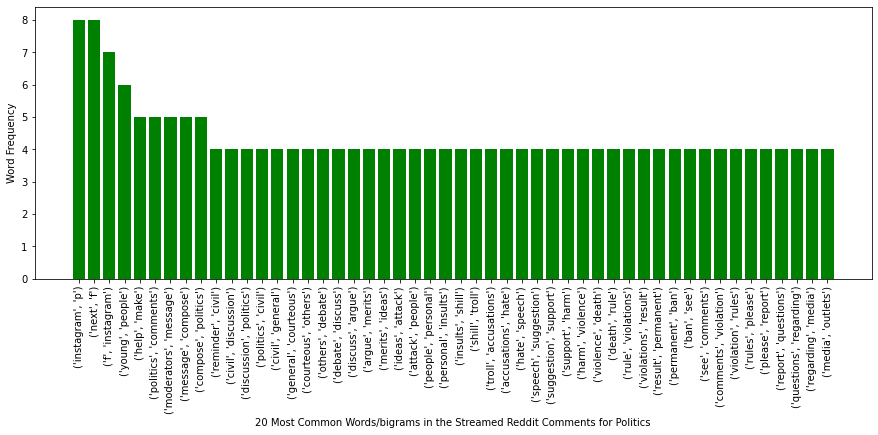

In [13]:
plot_bigrams(reddit) ## histogram for bigrams

### More Data Wrangling for Analyses and Visualization

In [14]:
########## 5. More Data Wrangling for Analyses and Visualization

[biden, sanders, trump, cruz] = [0,0,0,0] # initialize a list of var to store counts

for index, row in reddit.iterrows():
    biden += word_in_text('biden', row['cleaned_comments'])
    sanders += word_in_text('sanders', row['cleaned_comments'])
    trump += word_in_text('trump', row['cleaned_comments'])
    cruz += word_in_text('cruz', row['cleaned_comments'])

name_count = [biden, sanders, trump, cruz]


[democrats, republican] = [0,0] # initialize a list of var to store counts

for index, row in reddit.iterrows():
    democrats += word_in_text('democrat([s|ic]*)', row['cleaned_comments'])
    republican += word_in_text('republican', row['cleaned_comments'])

party_count = [democrats, republican]


names = ['biden', 'sanders', 'trump', 'cruz']
parties = ['democrats', 'republican']

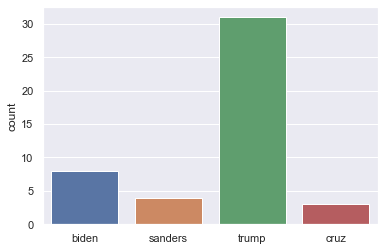

In [15]:
plot_key_words(names, name_count)

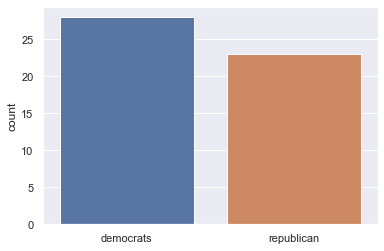

In [16]:
plot_key_words(parties, party_count)

### Word Cloud Visualization

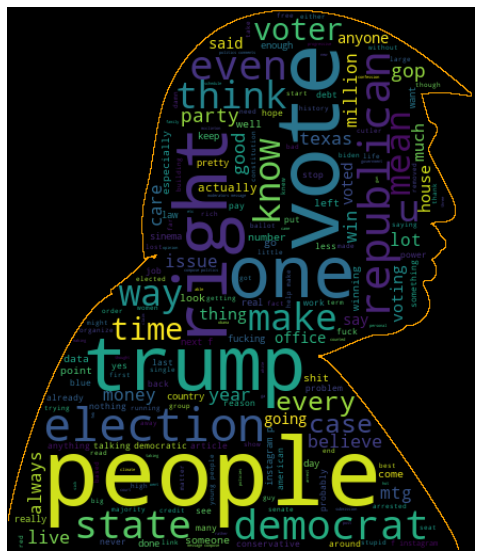

In [17]:
############ 6. Word Cloud
word_cloud(reddit)

Another wordcloud result when I streamed the Reddit comments a different time displayed as follows:

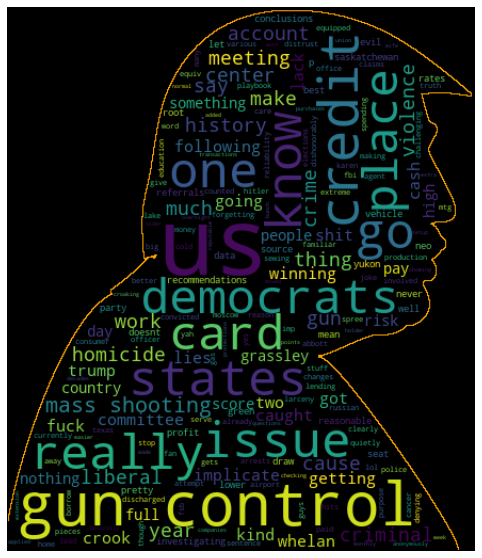